<a href="https://www.kaggle.com/code/akouaorsot/full-stack-data-science-ba-flight-reviews?scriptVersionId=141548854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
British Airways, one of the world's leading airlines, has been synonymous with excellence and reliability for decades. With a rich history and a commitment to providing exceptional customer experiences, British Airways continues to be a preferred choice for travelers worldwide.

As part of a challenging and rewarding data science project at British Airways, I had the opportunity to work on web scraping review data from the renowned Skytrax website. The goal was to collect valuable insights from customer reviews and leverage data-driven approaches to enhance the airline's services and customer satisfaction.

## Table of Contents


# Loading

In [1]:
## Data, math, and string manipulation
import os           # operating system
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math         # Math Operations
import re           # Regex
import string


## Categorical Encoding
import category_encoders as ce      # Feature encoding
from sklearn import preprocessing   # Target Variable Encoding

## Data Visualization
import matplotlib.pyplot as plt     # data visualization
import seaborn as sns               # Other visualization package
sns.set_style("darkgrid")

## Basic NLP
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator    # Wordcloud    
from PIL import Image               # Upload an image
import nltk                         # Manipulate linguistic data

## Machine Learning
from sklearn.linear_model import LinearRegression            # Simple Regression Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Importing the dataset
paths = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith("csv"):
            paths["csv"] = file_path
        else:
            paths[file_path.split('.')[1]] = file_path

paths

{'csv': '/kaggle/input/british-airways-passenger-reviews-2016-2023/British_Airway_Review.csv',
 'jpg': '/kaggle/input/wc-mask-image/istockphoto-1131327595-612x612.jpg'}

# Overview

In [3]:
# Snapshot of the first 5 rows
df = pd.read_csv(paths['csv'])
df.head()

,reviews,date,country,seat_type,recommended,stars,route,type_of_traveller
0,✅ Trip Verified | I had the most fantastic BA...,1st August 2023,Hong Kong,Business Class,yes,5,Heathrow to Las Vegas,Family Leisure
1,✅ Trip Verified | Couldn’t book in online. Ar...,31st July 2023,United Kingdom,Economy Class,no,3,Rome to Heathrow,Solo Leisure
2,✅ Trip Verified | London Heathrow to Mumbai in...,31st July 2023,Iceland,Business Class,yes,3,Gatwick to Venice,Solo Leisure
3,"✅ Trip Verified | Keflavík, Iceland to London ...",31st July 2023,Iceland,Business Class,yes,5,London to Luanda,Couple Leisure
4,✅ Trip Verified | Terrible Experience with Bri...,29th July 2023,Canada,Economy Class,no,5,Denver to Heathrow,Family Leisure


In [4]:
# Shape of data: No. of rows and columns
no_rows, no_cols = df.shape

# Check for missing values
null_values = df.isnull().sum().sum()

# No. of duplicates values
duplicates_n = df[df.duplicated()].shape[0]


# Diagnostics results
data_check = """
- The data has {0} rows and {1} columns
- There are {2} null/na values and {3} duplicated rows. 
""" 

print(data_check.format(no_rows, no_cols,
                        null_values, duplicates_n))


- The data has 2500 rows and 8 columns
- There are 0 null/na values and 0 duplicated rows. 



In [5]:
# # Examine unique values for each categorical variable
# """
# - col:
#     - 
# """
# Unique value counts for categorical columns
for col in df.columns[2:]:
    print(col)
    col_cats_count = df[col].value_counts(sort=True)
    n_cat = len(col_cats_count.keys())
    freq = dict(col_cats_count)
    if n_cat <= 10:
        print(n_cat)
        print(freq)
    else:
        print(n_cat)

country
67
seat_type
4
{'Economy Class': 1363, 'Business Class': 754, 'Premium Economy': 248, 'First Class': 135}
recommended
2
{'no': 1620, 'yes': 880}
stars
5
{3: 1137, 5: 682, 1: 227, 9: 227, 7: 227}
route
10
{'Heathrow to Las Vegas': 250, 'Rome to Heathrow': 250, 'Gatwick to Venice': 250, 'London to Luanda': 250, 'Denver to Heathrow': 250, 'BKK to LHR': 250, 'London to Tampa': 250, 'London to Sydney': 250, 'LHR to CPT': 250, 'BLR to LHR': 250}
type_of_traveller
4
{'Couple Leisure': 1000, 'Family Leisure': 500, 'Solo Leisure': 500, 'Business': 500}


# Exploratory Data Analysis

In [6]:
# Traveller Profiling Analysis
profile_columns = [
    'country',
    'seat_type',
    'type_of_traveller'
]

# Subset of data with demographic information
profile_stats = df[profile_columns].describe()
profile_stats

,country,seat_type,type_of_traveller
count,2500,2500,2500
unique,67,4,4
top,United Kingdom,Economy Class,Couple Leisure
freq,1552,1363,1000


### **Takeaway**: 
#### Though BA has 60+ countries represented, the vast majory of travellers from this sample are from the United Kingdom (~67%).

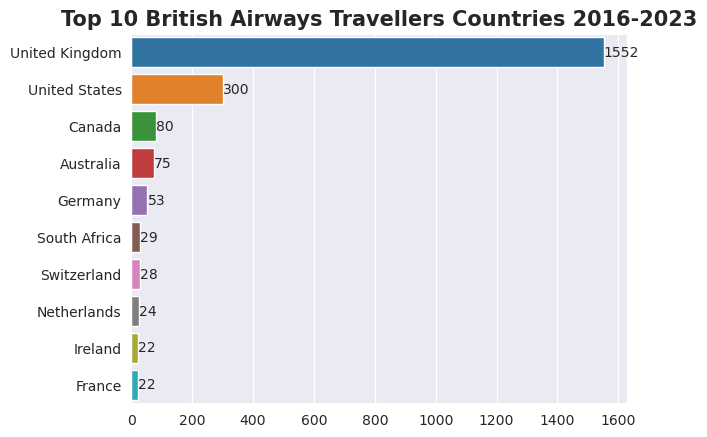

In [7]:
# Obtain value counts by country
country_freq = df['country'].value_counts(normalize=False, sort=True)
countries_top = list(country_freq.index)[:10]
freq_counts_top = list(country_freq.values)[:10]

# Disribution of top traverlers' origin countries
ax = sns.barplot(x=freq_counts_top, y=countries_top, 
            orient = 'h'
       )

ax.bar_label(ax.containers[0])
plt.title('Top 10 British Airways Travellers Countries 2016-2023', fontsize=15, fontweight='bold')
plt.show()

### **Takeaway**: 
#### In calculating and visualizing the breakdown of 2500 BA Flights from 2016-2023, we can assume the average BA flight to be a couple travelling for leisure seating in economic class

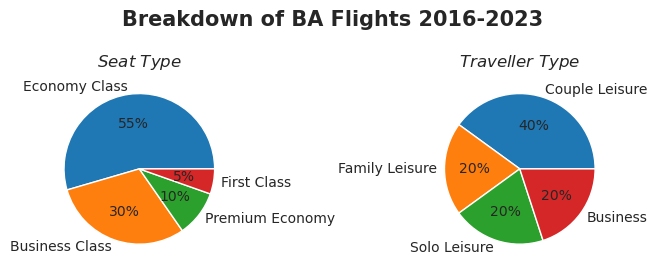

In [8]:
# Proportions by seat type
seats_freq = df['seat_type'].value_counts(sort=True)
seat_type = list(seats_freq.index)
seat_counts = list(seats_freq.values)

# Proportions by seat type
type_freq = df['type_of_traveller'].value_counts(sort=True)
types = list(type_freq.index)
type_counts = list(type_freq.values)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Breakdown of BA Flights 2016-2023", y=0.8, fontsize=15, fontweight='bold')
ax1.pie(labels=seat_type, x=seat_counts, autopct='%.0f%%')
ax1.set_title('${Seat}$ ${Type}$')
ax2.pie(labels=types, x=type_counts , autopct='%.0f%%')
ax2.set_title("${Traveller}$ ${Type}$")

fig.tight_layout(pad=.75)
#plt.title('Breakdown of Seat Type & Traveller Type at BA Flights 2016-2023')
plt.show()

### **Takeaway**: 
#### From the graph below, we cannot confidently assume all travellers in more premium seats would score their flights better. Though the outlier on the upper bound with score of 7 & 9 mostly occured with 

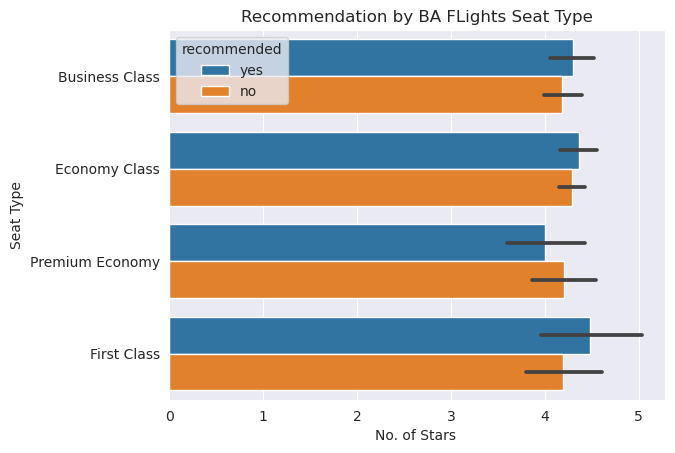

In [9]:
# Assess recommendation based on No. of stars given and seat type
sns.barplot(
    data = df,
    x='stars', 
    y='seat_type',
    hue ='recommended',
    orient='h')

plt.title('Recommendation by BA FLights Seat Type')
plt.xlabel('No. of Stars ')
plt.ylabel('Seat Type')
plt.show()

# Feature Transformation/Engineering

With data cleaning taking up a considerable chunk of data science workflow, it is critical to know how to assess, improve, and produce data quality. Every subsequent steps from analysis to machine learning modeling hinges on having good data. And so, this project will focus on practicing best practices when it comes to data cleaning to ensure higher quality and usability. 

In that vein, we examined various sources, especially the following three in an attempt to draft a comprehensive map for the cleaning process: 
* [World Bank Data Cleaning Checklist](https://dimewiki.worldbank.org/Checklist:_Data_Cleaning)
* [Mariann Beargie on Medium](https://mariannbea.medium.com/are-you-sure-your-data-is-completely-clean-use-this-checklist-to-help-8cb415a8b0e0)
* [DataCamp Data Cleaning Infographic](https://www.datacamp.com/blog/infographic-data-cleaning-checklist)

Based on the sources above, we modelled our steps and ensure that we could produce a score on the scale of 1 to 10 before and after cleaning.

In [10]:
# Create a different column "trip verified" to seperate them properly
df['trip_verified'] = np.where(df['reviews'].str.contains("Trip Verified"), 1, 0) 

# Capture the main content of the reviews and create a list of each word 
df['reviews_verif_drop'] = df['reviews'].str.replace("✅ Trip Verified \| ","").str.strip()
df['reviews_bag_of_words'] = df['reviews_verif_drop'].str.split(" ")

# Converting 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# New snapshot of first 5 rows after transformation
df.head()

/tmp/ipykernel_20/2525839514.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['reviews_verif_drop'] = df['reviews'].str.replace("✅ Trip Verified \| ","").str.strip()


,reviews,date,country,seat_type,recommended,stars,route,type_of_traveller,trip_verified,reviews_verif_drop,reviews_bag_of_words
0,✅ Trip Verified | I had the most fantastic BA...,2023-08-01,Hong Kong,Business Class,yes,5,Heathrow to Las Vegas,Family Leisure,1,I had the most fantastic BA Flight today. The ...,"[I, had, the, most, fantastic, BA, Flight, tod..."
1,✅ Trip Verified | Couldn’t book in online. Ar...,2023-07-31,United Kingdom,Economy Class,no,3,Rome to Heathrow,Solo Leisure,1,Couldn’t book in online. Arrived at check in t...,"[Couldn’t, book, in, online., Arrived, at, che..."
2,✅ Trip Verified | London Heathrow to Mumbai in...,2023-07-31,Iceland,Business Class,yes,3,Gatwick to Venice,Solo Leisure,1,London Heathrow to Mumbai in a Boeing 787-8 in...,"[London, Heathrow, to, Mumbai, in, a, Boeing, ..."
3,"✅ Trip Verified | Keflavík, Iceland to London ...",2023-07-31,Iceland,Business Class,yes,5,London to Luanda,Couple Leisure,1,"Keflavík, Iceland to London Heathrow on an A32...","[Keflavík,, Iceland, to, London, Heathrow, on,..."
4,✅ Trip Verified | Terrible Experience with Bri...,2023-07-29,Canada,Economy Class,no,5,Denver to Heathrow,Family Leisure,1,Terrible Experience with British Airways. I bo...,"[Terrible, Experience, with, British, Airways...."


In [11]:
# Some routes have airport codes while others don't
# List of airports codes to standardize the information in departure and arrival locations
airport_codes = {
    "London": "LHR",
    "Heathrow": "LHR",
    "Las Vegas": "LAS",
    "Luanda": "LAD",
    "Denver": "DEN",
    "Rome": "FCO",
    "Gatwick": "LGW",
    "Venice": "VCE",
    "Tampa": "TPA",
    "Sydney": "SYD",
    "Bangkok": "BKK",
    "Cape Town": "CPT",
    "Bangalore": "BLR"
}

df = df.apply(lambda x: x.replace(airport_codes, regex=True))
df.head()

,reviews,date,country,seat_type,recommended,stars,route,type_of_traveller,trip_verified,reviews_verif_drop,reviews_bag_of_words
0,✅ Trip Verified | I had the most fantastic BA...,2023-08-01,Hong Kong,Business Class,yes,5,LHR to LAS,Family Leisure,1,I had the most fantastic BA Flight today. The ...,"[I, had, the, most, fantastic, BA, Flight, tod..."
1,✅ Trip Verified | Couldn’t book in online. Ar...,2023-07-31,United Kingdom,Economy Class,no,3,FCO to LHR,Solo Leisure,1,Couldn’t book in online. Arrived at check in t...,"[Couldn’t, book, in, online., Arrived, at, che..."
2,✅ Trip Verified | LHR LHR to Mumbai in a Boein...,2023-07-31,Iceland,Business Class,yes,3,LGW to VCE,Solo Leisure,1,LHR LHR to Mumbai in a Boeing 787-8 in Busines...,"[London, Heathrow, to, Mumbai, in, a, Boeing, ..."
3,"✅ Trip Verified | Keflavík, Iceland to LHR LHR...",2023-07-31,Iceland,Business Class,yes,5,LHR to LAD,Couple Leisure,1,"Keflavík, Iceland to LHR LHR on an A320 in Bus...","[Keflavík,, Iceland, to, London, Heathrow, on,..."
4,✅ Trip Verified | Terrible Experience with Bri...,2023-07-29,Canada,Economy Class,no,5,DEN to LHR,Family Leisure,1,Terrible Experience with British Airways. I bo...,"[Terrible, Experience, with, British, Airways...."


In [12]:

# In the airline industry, seat pricing implies a given order. 
# So, we will encode accordingly
ordinal_encoder = ce.OrdinalEncoder(cols=['seat_type', 'stars'],return_df=True,
                       mapping=[
                           {'col':'seat_type',
                            'mapping':{'Economy Class':0,'Premium Economy':1,
                                            'Business Class':2,'First Class':3}},
                           {'col':'stars',
                            'mapping':{1:0, 3:1, 5:2,7:3, 9:4}}])


# 'recommended' and 'trip_verified' are binary categorical variables so, will be encoded as such
binary_encoder= ce.BinaryEncoder(cols='trip_verified',return_df=True)

## 'type_of_traveller' and 'route' are both nominal categorical variables
# With 4 and 10 categories respectively
#So we will one-hot-encoding
one_hot_encoder = ce.OneHotEncoder(cols=["type_of_traveller", "route"], use_cat_names=True,
                                   return_df=True)

# The 'country' column is categorical feature, but with 67 distinct entities
# To avoid increasing the dimensionality in the data set, we
# used frequency encoding. 
freq_encoder = ce.CountEncoder(cols=['country'], normalize=True, return_df=True)


In [13]:
def encoding_cat_vars(data, encoders):
    """ Encoding categorical variables

    Inputs
    -------
        data: dataframe
        encoders: list of dictionaries with the encoders

    Returns transformed dataframe
    """

    # Looping through all encoders for an in-place encoding
    for enc in encoders:
        # Define the key-value pair in context
        enc_name = list(enc.keys())[0]
        enc_vars = list(enc.values())[0]

        # Special Case for frequency encoding
        if enc_name == 'freq_encoder':
            # New columns from list of columns to encode 
            # with a frequency encoder
            col = enc_vars[0]
            func = enc_vars[1]
            data[col+'_encoded'] = func.fit_transform(data[col])

        # For all other cases, apply 'fit_transform' inplace
        else:
            func = enc_vars
            data = func.fit_transform(data)

    # New dataframe after encoding
    return data


# Applying all changes using the defined function above
df_final = encoding_cat_vars(data = df, 
                               encoders = [{'ordinal_encoder': ordinal_encoder},
                                           {'binary_encoder': binary_encoder},
                                           {'one_hot_encoder': one_hot_encoder},
                                           {'freq_encoder': ['country', freq_encoder]}
                                            ]
                               )

df_final.head()

,reviews,date,country,seat_type,recommended,stars,route_LHR to LAS,route_FCO to LHR,route_LGW to VCE,route_LHR to LAD,...,route_BLR to LHR,type_of_traveller_Family Leisure,type_of_traveller_Solo Leisure,type_of_traveller_Couple Leisure,type_of_traveller_Business,trip_verified_0,trip_verified_1,reviews_verif_drop,reviews_bag_of_words,country_encoded
0,✅ Trip Verified | I had the most fantastic BA...,2023-08-01,Hong Kong,2,yes,2,1,0,0,0,...,0,1,0,0,0,0,1,I had the most fantastic BA Flight today. The ...,"[I, had, the, most, fantastic, BA, Flight, tod...",0.0052
1,✅ Trip Verified | Couldn’t book in online. Ar...,2023-07-31,United Kingdom,0,no,1,0,1,0,0,...,0,0,1,0,0,0,1,Couldn’t book in online. Arrived at check in t...,"[Couldn’t, book, in, online., Arrived, at, che...",0.6208
2,✅ Trip Verified | LHR LHR to Mumbai in a Boein...,2023-07-31,Iceland,2,yes,1,0,0,1,0,...,0,0,1,0,0,0,1,LHR LHR to Mumbai in a Boeing 787-8 in Busines...,"[London, Heathrow, to, Mumbai, in, a, Boeing, ...",0.0012
3,"✅ Trip Verified | Keflavík, Iceland to LHR LHR...",2023-07-31,Iceland,2,yes,2,0,0,0,1,...,0,0,0,1,0,0,1,"Keflavík, Iceland to LHR LHR on an A320 in Bus...","[Keflavík,, Iceland, to, London, Heathrow, on,...",0.0012
4,✅ Trip Verified | Terrible Experience with Bri...,2023-07-29,Canada,0,no,2,0,0,0,0,...,0,1,0,0,0,0,1,Terrible Experience with British Airways. I bo...,"[Terrible, Experience, with, British, Airways....",0.0320


# Target Variable

In [14]:
## In assuming that the binary 'recommended' column captures the target variables

# converting type of columns to 'category'
df_final['recommended'] = df_final['recommended'].astype('category')

# Assigning numerical values and storing in another column
df_final['recommended'] = df_final['recommended'].cat.codes
df_final.head()

,reviews,date,country,seat_type,recommended,stars,route_LHR to LAS,route_FCO to LHR,route_LGW to VCE,route_LHR to LAD,...,route_BLR to LHR,type_of_traveller_Family Leisure,type_of_traveller_Solo Leisure,type_of_traveller_Couple Leisure,type_of_traveller_Business,trip_verified_0,trip_verified_1,reviews_verif_drop,reviews_bag_of_words,country_encoded
0,✅ Trip Verified | I had the most fantastic BA...,2023-08-01,Hong Kong,2,1,2,1,0,0,0,...,0,1,0,0,0,0,1,I had the most fantastic BA Flight today. The ...,"[I, had, the, most, fantastic, BA, Flight, tod...",0.0052
1,✅ Trip Verified | Couldn’t book in online. Ar...,2023-07-31,United Kingdom,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,Couldn’t book in online. Arrived at check in t...,"[Couldn’t, book, in, online., Arrived, at, che...",0.6208
2,✅ Trip Verified | LHR LHR to Mumbai in a Boein...,2023-07-31,Iceland,2,1,1,0,0,1,0,...,0,0,1,0,0,0,1,LHR LHR to Mumbai in a Boeing 787-8 in Busines...,"[London, Heathrow, to, Mumbai, in, a, Boeing, ...",0.0012
3,"✅ Trip Verified | Keflavík, Iceland to LHR LHR...",2023-07-31,Iceland,2,1,2,0,0,0,1,...,0,0,0,1,0,0,1,"Keflavík, Iceland to LHR LHR on an A320 in Bus...","[Keflavík,, Iceland, to, London, Heathrow, on,...",0.0012
4,✅ Trip Verified | Terrible Experience with Bri...,2023-07-29,Canada,0,0,2,0,0,0,0,...,0,1,0,0,0,0,1,Terrible Experience with British Airways. I bo...,"[Terrible, Experience, with, British, Airways....",0.0320


# Final Dataset

In [15]:
# After all pre-processing steps,
# Save onto a new csv file
df_final.to_csv("BA_Flights_Reviews_processed.csv", header=True)

# Natural Language Processing (NLP)

In [16]:
# Create a mega-text from all reviews 
text = " ".join(review for review in df_final['reviews_verif_drop'])

# Stopwords
stopwords = set(STOPWORDS)
stopwords.update(["BA", "British Airway", "British Airways", "flight", 'flights',
                  'LHR', 'British', 'Airway', 'Airways'])

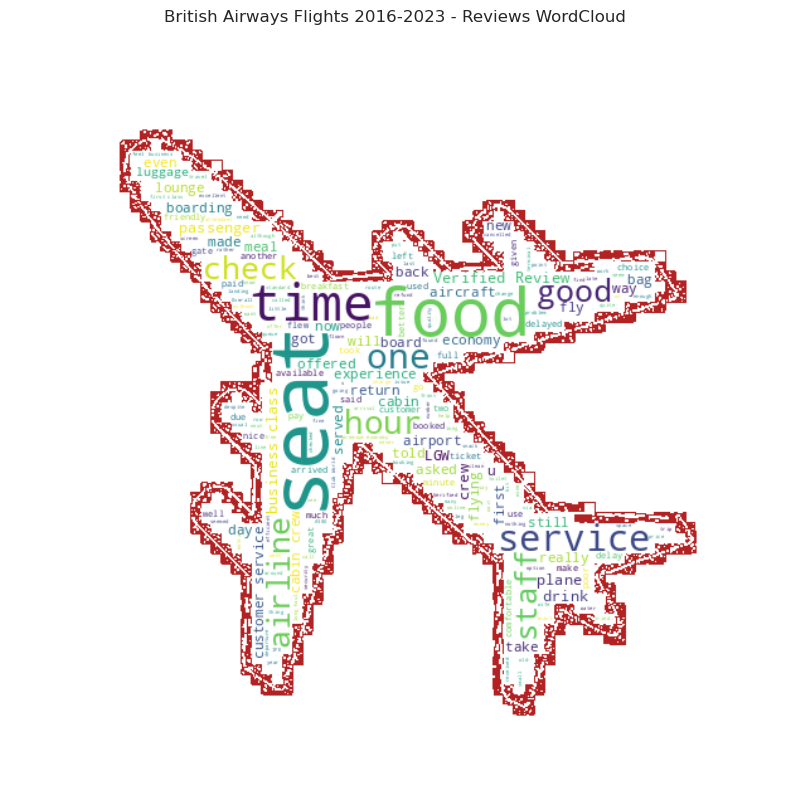

In [17]:
# Mask for image countouring of wordcloud
mask = np.array(Image.open(paths['jpg']))
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
# Transform your mask into a new one that will work with the function:
transformed_mask = np.ndarray((mask.shape[0], mask.shape[1]), np.int32)

for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[i]))
    
# Display wordcloud
wc = WordCloud(background_color="white", max_words=1000, 
                      mask=transformed_mask,
                      stopwords=stopwords, contour_width=1, 
                      contour_color='firebrick')

wc.generate(text)

# store to file
wc.to_file("ba_flights_wordcloud.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("British Airways Flights 2016-2023 - Reviews WordCloud")
plt.show()

In [18]:
# Create a cleaner versions of each reviews
# Assign sentiment value to each 
# Store in another column
# Check if strong correlation between that and recommended
# reviews_clean = df['reviews_verif_drop'].str.lower().replace('[^\w\s]|','')
# reviews_clean

In [19]:
# # from pprint import pprint
# from nltk.sentiment import SentimentIntensityAnalyzer
# # Sentiment Analysis
# bag_of_words = nltk.word_tokenize(text)
# words = [w for w in bag_of_words if w.lower() not in stopwords]
# # fd = nltk.FreqDist(words)
# # fd.most_common(3)

# sia = SentimentIntensityAnalyzer()
# sia.polarity_scores(text)

# Correlation Analysis

/tmp/ipykernel_20/1208343902.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_final.corr()


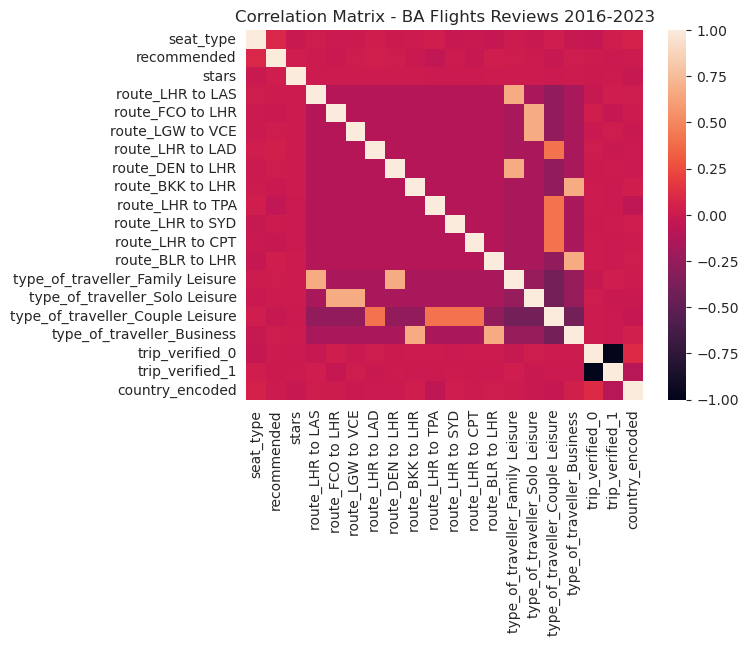

In [20]:
# Computing the correlation matrix across all dependent and independent variables
nonnum_cols = ['reviews', 'date', 'country', 
                 'reviews_verif_drop','reviews_bag_of_words']
corr_matrix = df_final.corr()

# Visualizing matrix as heatmap
sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation Matrix - BA Flights Reviews 2016-2023")
plt.show()

In [21]:
# Isolating correlation coefficient for target variable only
np.round(corr_matrix['recommended'], 2)

seat_type                           0.08
recommended                         1.00
stars                               0.02
route_LHR to LAS                    0.00
route_FCO to LHR                   -0.01
route_LGW to VCE                    0.01
route_LHR to LAD                    0.04
route_DEN to LHR                    0.01
route_BKK to LHR                   -0.01
route_LHR to TPA                   -0.05
route_LHR to SYD                    0.00
route_LHR to CPT                   -0.02
route_BLR to LHR                    0.03
type_of_traveller_Family Leisure    0.01
type_of_traveller_Solo Leisure      0.00
type_of_traveller_Couple Leisure   -0.02
type_of_traveller_Business          0.01
trip_verified_0                     0.00
trip_verified_1                    -0.00
country_encoded                     0.00
Name: recommended, dtype: float64

# Machine Learning

In [22]:
# Use recommended as target variable
# Use label encoding

# NLP

# Business Analysis & Recommendations